# Detección de Diabetes con Espectroscopia Raman utilizando técnicas de aprendizaje supervisado

In [1]:
# Se importan las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from BaselineRemoval import BaselineRemoval

from statistics import mode

import time
from datetime import timedelta

In [2]:
""" Se definen las funciones que se van a usar para imprimir gráficas de los espectros Raman """

# Imprime la gráfica de un espectro Raman
def plot_df(x, y, title="", x_label=r'Desplazamiento Raman [$cm^{-1}$]', y_label='Intensidad', dpi=100, color='tab:red'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color=color)
    plt.gca().set(title=title, xlabel=x_label, ylabel=y_label)
    plt.show()

# Imprime la gráfica de dos espectros Raman
def plot_df_compare(x, y_1, y_2, title="", x_label=r'Desplazamiento Raman [$cm^{-1}$]', y_label='Intensidad', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y_1, color='tab:red')
    plt.plot(x, y_2, color='tab:blue')
    plt.gca().set(title=title, xlabel=x_label, ylabel=y_label)
    plt.show()

In [3]:
# Se cargan los datos de los distintos archivos y se asignan a un Data Frame gracias a la librería pandas
RamanEarLobeDF = pd.read_csv('data/earLobe.csv')
RamanInnerArmDF = pd.read_csv('data/innerArm.csv')
RamanThumbNailDF = pd.read_csv('data/thumbNail.csv')
RamanVeinDF = pd.read_csv('data/vein.csv')

## Preprocesamiento

In [4]:
""" Se definen las funciones que se usarán para el preprocesamiento de los datos """

# Función que elimina la primera columna y se recortan los espectros a la región de 800-1800 cm^-1. Este rango fue seleccionado para que coincidiera con la región espectral de los productos finales de glicación avanzada (AGE). Posteriormente, se elimina la primera fila, que contiene los números de onda
def prepare_df (raman_df):
    raman_df = raman_df.drop(["patientID"], axis=1)
    raman_df = raman_df.drop(raman_df.iloc[:, 1:801], axis=1)
    raman_df = raman_df.drop(raman_df.iloc[:, 1002:], axis=1)
    raman_df = raman_df.drop([0])
    return raman_df

# Función imprime todos los espectros de un data frame para analizarlos
def print_raman_shift (raman_df):
    for index, paciente in raman_df.iterrows():
            plot_df(x=list(range(800, 1801)), y=paciente[1:], title=f'Paciente ' + f'DM2 {index}' if paciente["has_DM2"] == 1 else f'Ctrl {index}', color='tab:red' if paciente["has_DM2"] == 1 else 'tab:blue')

# Función que comparan dos formas de eliminar la fluorescencia, con IModPoly() y ZhangFit() de la librería BaselineRemoval, observada en los espectros Raman
def compare_remove_fluorescence_functions (raman_df):
    for index, paciente in raman_df.iterrows():
        plot_df_compare(x=list(range(800, 1801)), y_1=BaselineRemoval(paciente[1:].tolist()).IModPoly(2), y_2=BaselineRemoval(paciente[1:].tolist()).ZhangFit(), title=f'Paciente' + f'DM2 {index}' if paciente["has_DM2"] == 1 else f'Ctrl {index}')

# Función que elimina la fluorescencia con ZhangFit()
def remove_fluorescence (raman_df):
    raman_df_transform = raman_df.copy()
    for index, paciente in raman_df_transform.iterrows():
        raman_df_transform.iloc[index-1,1:] = BaselineRemoval(paciente[1:].tolist()).ZhangFit()
    return raman_df_transform

# Función que calcula la media de los espectros Raman agrupados pacientes con DM2 y Ctrl para compararlos en una gráfica
def compare_means_raman (raman_df):
    raman_df_dm2_mean = raman_df.loc[raman_df['has_DM2'] == 1].iloc[:,1:].mean()
    raman_df_ctrl_mean = raman_df.loc[raman_df['has_DM2'] == 0].iloc[:,1:].mean()
    plot_df_compare(x=list(range(800, 1801)), y_1=raman_df_dm2_mean, y_2=raman_df_ctrl_mean, title='Media DM2 vs Ctrl')

# Función que estandariza los datos restando la media y dividiendo por la desviación estándar con StandardScaler()
def standardize (raman_df):
    scaler = StandardScaler()
    raman_df.iloc[:,1:] = scaler.fit_transform(raman_df.iloc[:,1:])
    return raman_df

# Función que aplica PCA y muestra un una gráfica el acumulado de varianza explicada en las nuevas dimensiones
def apply_pca (raman_df):
    pca=PCA(.95)
    pca.fit(raman_df.iloc[:,1:])
    raman_df_pca = pca.transform(raman_df.iloc[:,1:])
    n_pca = raman_df_pca.shape[1]
    print("Dimensiones de X_pca", raman_df_pca.shape)
    print(pca.explained_variance_ratio_)
    print('Varianza explicada con 5 componentes:',sum(pca.explained_variance_ratio_[0:5]))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Número de componentes')
    plt.ylabel('Varianza explicada acumulada')
    plt.show()

    # Se crea el data frame con el número componentes principales obtenidas
    index_pca = []
    for i in range(n_pca):
        index_pca.append(f'PC{i+1}')

    raman_df_pca = pd.DataFrame(raman_df_pca, columns=index_pca)
    # Para el correcto funcionamiento, se cambia el inicio del index a 1
    raman_df_pca.index += 1
    #S e inserta el target
    raman_df_pca.insert(loc = 0,
              column = 'has_DM2',
              value = raman_df['has_DM2'].loc[1:])
    return raman_df_pca

# Función que divide el data frame en conjuntos de train 80% y test 20%
def raman_train_test_split(raman_df):
    return train_test_split(raman_df.iloc[:,1:], raman_df['has_DM2'], test_size=0.1)

# Función que realiza todas las funciones de preprocesamiento
def df_preprocessing (raman_df):
    raman_df = prepare_df(raman_df)
    raman_df = remove_fluorescence(raman_df)
    raman_df = standardize(raman_df)
    return raman_df

# Función que realiza todas las funciones de preprocesamiento además de aplicar PCA
def df_preprocessing_pca (raman_df):
    raman_df = prepare_df(raman_df)
    raman_df = remove_fluorescence(raman_df)
    raman_df = standardize(raman_df)
    raman_df = apply_pca(raman_df)
    return raman_df

## Modelos de aprendizaje automático

In [5]:
""" Se definen las funciones para calcular y visualizar las métricas """

# Función que calcula las métricas utilizando sklearn
def get_metrics(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'conf_matrix' : conf_matrix, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall, 'f1' : f1}

# Función que pinta la matriz de confusión y métricas
def plot_metrics(metrics, title):

    #Código de matplotlib para graficar
    plt.figure(figsize=(3, 3))
    matrix = pd.DataFrame(metrics['conf_matrix'],
                          columns=["0 : Ctrl", "1 : DM2"])
    plt.matshow(matrix, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Predichas")
    plt.ylabel("Reales")
    plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45)
    plt.yticks(range(len(matrix.columns)), matrix.columns)
    labels = (("Verdaderos\nnegativos", "Falsos\nnegativos"),
                 ("Falsos\npositivos", "Verdaderos\npositivos"))
    for i in range(len(matrix.columns)):
        for j in range(len(matrix.columns)):
            plt.text(i, j + 0.14, str(matrix.iloc[j, i]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, labels[i][j],
                     fontsize=11.5, ha="center", va="center")
    plt.text(1.60, -0.30, title, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Recall: %0.2f" % metrics['recall'], fontsize=20)
    plt.text(2.1, 0.70, "Accuracy: %0.2f" % metrics['accuracy'], fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % metrics['precision'], fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % metrics['f1'], fontsize=20)
    plt.show()

In [6]:
""" Se definen las funciones para calcular y visualizar las métricas """

# Función que búsqueda del mejor modelo utilizando GridSearchCV() o RandomizedSearchCV(), según se le indique
def best_model_search_cv (estimator, params, df_raman, df_raman_label, search_type):
    start_time = time.time()

    # Se realiza la búsqueda
    if search_type == 'GridSearchCV':
        search = GridSearchCV(estimator=estimator, param_grid=params, scoring={'recall':'recall', 'accuracy':'accuracy', 'f1':'f1', 'precision':'precision'}, refit='accuracy', n_jobs=-1, cv=LeaveOneOut(), return_train_score=True)
    else:
        search = RandomizedSearchCV(estimator = estimator, param_distributions = params, n_iter = 100, scoring={'recall':'recall', 'accuracy':'accuracy', 'f1':'f1', 'precision':'precision'}, refit='recall', n_jobs=-1, cv=LeaveOneOut(), return_train_score=True)

    search.fit(df_raman.iloc[:,1:], df_raman['has_DM2'])

    # Resultados
    print('------------------------------------------------------------------------')
    print(f'Mejores resultados para {df_raman_label}')
    print(f"recall:{search.cv_results_['mean_test_recall'][search.best_index_]}, accuracy:{search.cv_results_['mean_test_accuracy'][search.best_index_]}, precision:{search.cv_results_['mean_test_precision'][search.best_index_]}, f1:{search.cv_results_['mean_test_f1'][search.best_index_]}")
    print(f'Hiperparámetros: {search.best_params_}')
    print(f'Tiempo transcurrido (best_model_grid_search_cv): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return search

# Función que imprime las métricas de todos los modelos
def iter_best_models_plot_metrics (iter_search, model_label):
    # Se obtienen las métricas para cada data frame
    for search_key, search_value in iter_search.items():
        y_pred = cross_val_predict(search_value['search'].best_estimator_, search_value['df_raman'].iloc[:,1:], search_value['df_raman']['has_DM2'], cv=LeaveOneOut())
        metrics = get_metrics(search_value['df_raman']['has_DM2'], y_pred)
        plot_metrics(metrics, model_label + "\n" + search_key)

# Función que búsqueda del mejor modelo y lo imprime para todos los data frames
def iter_df_plot_metrics (estimator, df_raman, params, model_label, search_type):
    # Se obtiene el modelo óptimo para cada data frame
    iter_search = {}
    for df_key, df_value in df_raman.items():
        search = best_model_search_cv(estimator, params, df_value, df_key, search_type)
        iter_search[df_key] = {'search' : search, 'df_raman' : df_value}
    iter_best_models_plot_metrics (iter_search, model_label)

In [7]:
RamanEarLobeDF_preprocessed = df_preprocessing(RamanEarLobeDF)
RamanInnerArmDF_preprocessed = df_preprocessing(RamanInnerArmDF)
RamanThumbNailDF_preprocessed = df_preprocessing(RamanThumbNailDF)
RamanVeinDF_preprocessed = df_preprocessing(RamanVeinDF)
RamanDF_preprocessed = {'EarLobe' : RamanEarLobeDF_preprocessed,
                        'InnerArm' : RamanInnerArmDF_preprocessed,
                        'ThumbNail' : RamanThumbNailDF_preprocessed,
                        'Vein' : RamanVeinDF_preprocessed}

Dimensiones de X_pca (20, 12)
[0.58652943 0.15351859 0.06862393 0.03510903 0.02383198 0.01738268
 0.01552876 0.01431898 0.01299144 0.01133923 0.0102168  0.00891572]
Varianza explicada con 5 componentes: 0.8676129600227221


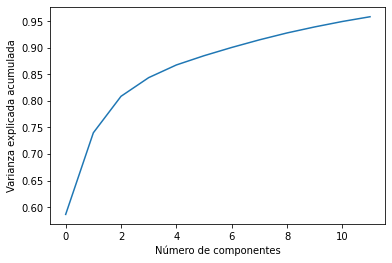

Dimensiones de X_pca (20, 12)
[0.64469483 0.11374171 0.05166191 0.03316092 0.02153084 0.01568177
 0.01330198 0.01239332 0.0118334  0.01117849 0.01093558 0.01003453]
Varianza explicada con 5 componentes: 0.8647902032371606


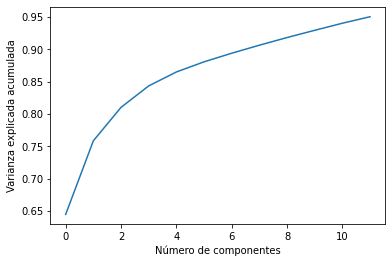

Dimensiones de X_pca (20, 11)
[0.6677955  0.09513463 0.06292486 0.04086866 0.02908171 0.01630976
 0.01110785 0.01000491 0.00868286 0.00786968 0.00756529]
Varianza explicada con 5 componentes: 0.8958053649254455


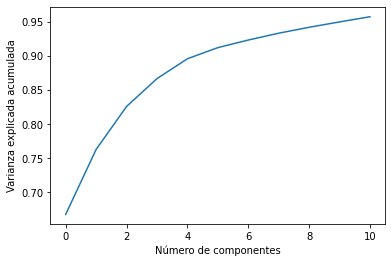

Dimensiones de X_pca (20, 14)
[0.54342802 0.14903546 0.07064525 0.03598282 0.02956338 0.01923196
 0.0170476  0.01609422 0.01583872 0.01500818 0.01345601 0.01251607
 0.01207391 0.01064604]
Varianza explicada con 5 componentes: 0.8286549235562187


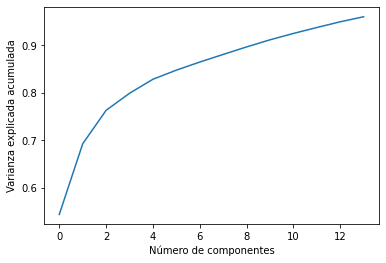

In [8]:
RamanEarLobeDF_preprocessed_pca = df_preprocessing_pca(RamanEarLobeDF)
RamanInnerArmDF_preprocessed_pca = df_preprocessing_pca(RamanInnerArmDF)
RamanThumbNailDF_preprocessed_pca = df_preprocessing_pca(RamanThumbNailDF)
RamanVeinDF_preprocessed_pca = df_preprocessing_pca(RamanVeinDF)
RamanDF_preprocessed_pca = {'EarLobe PCA' : RamanEarLobeDF_preprocessed_pca,
                            'InnerArm PCA' : RamanInnerArmDF_preprocessed_pca,
                            'ThumbNail PCA' : RamanThumbNailDF_preprocessed_pca,
                            'Vein PCA' : RamanVeinDF_preprocessed_pca}

In [9]:
# Se unen los 8 data frames para iterarlos y obtener las métricas
RamanDF_preprocessed.update(RamanDF_preprocessed_pca)

In [10]:
RamanInnerArmDF.drop([0]).describe()

,has_DM2,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var3152,Var3153,Var3154,Var3155,Var3156,Var3157,Var3158,Var3159,Var3160,Var3161
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,0.550000,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.510418,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.000000,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### RNA

In [11]:
# Sen define los hiperparámetros para la búsqueda
param_grid_rna = dict()
param_grid_rna['hidden_layer_sizes'] = [5, 10, 20, 50, 100]
param_grid_rna['batch_size'] = [2, 5, 10, 20]
param_grid_rna['activation'] = ['identity', 'logistic', 'tanh', 'relu']
param_grid_rna['solver'] = ['lbfgs', 'sgd', 'adam']
param_grid_rna['alpha'] = [0.0001, 0.05]
param_grid_rna['learning_rate'] = ['constant', 'invscaling', 'adaptive']
param_grid_rna['momentum'] = [0.0001, 0.05]

------------------------------------------------------------------------
Mejores resultados para EarLobe
recall:0.45, accuracy:0.75, precision:0.45, f1:0.45
Hiperparámetros: {'solver': 'sgd', 'momentum': 0.05, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 20, 'batch_size': 10, 'alpha': 0.05, 'activation': 'logistic'}
Tiempo transcurrido (best_model_grid_search_cv): 0:13:43.850368
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para InnerArm
recall:0.45, accuracy:0.75, precision:0.45, f1:0.45
Hiperparámetros: {'solver': 'sgd', 'momentum': 0.05, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 20, 'batch_size': 10, 'alpha': 0.05, 'activation': 'tanh'}
Tiempo transcurrido (best_model_grid_search_cv): 0:15:51.613996
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores 

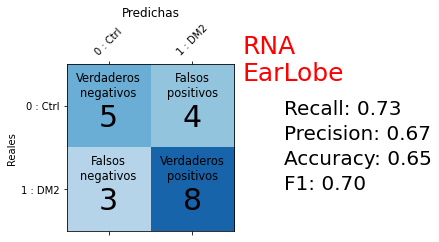

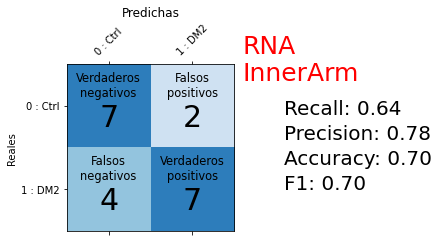

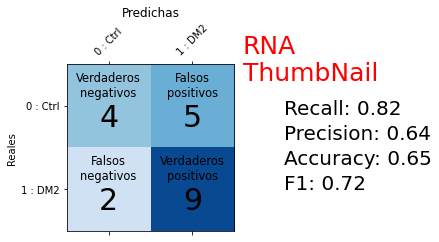

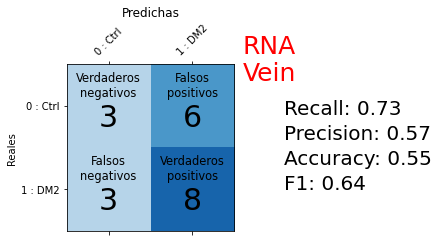

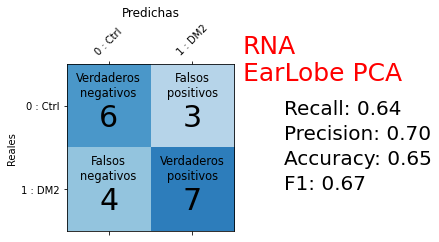

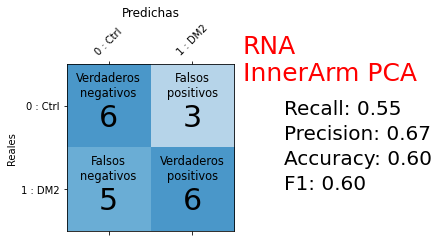

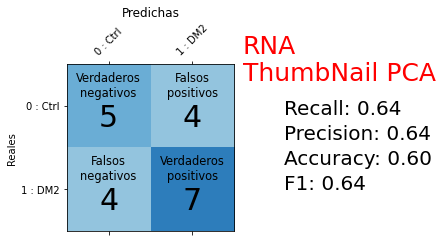

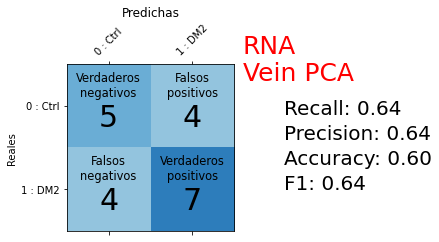

Tiempo transcurrido RNA: 1:22:06.797621


In [12]:
start_time_rna = time.time()
iter_df_plot_metrics(MLPClassifier(), RamanDF_preprocessed, param_grid_rna, 'RNA', 'RandomizedSearchCV')
print(f'Tiempo transcurrido RNA: {timedelta(seconds=(time.time() - start_time_rna))}')

### SVM

In [13]:
# Se definen los hiperparámetros para la búsqueda
param_grid_svm = dict()
param_grid_svm['C'] = [0.1, 1, 10, 100]
param_grid_svm['gamma'] = [0.1, 1, 10, 100]
param_grid_svm['kernel'] = ['linear', 'rbf', 'sigmoid']

------------------------------------------------------------------------
Mejores resultados para EarLobe
recall:0.45, accuracy:0.7, precision:0.45, f1:0.45
Hiperparámetros: {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:12.281680
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para InnerArm
recall:0.4, accuracy:0.7, precision:0.4, f1:0.4
Hiperparámetros: {'C': 1, 'gamma': 10, 'kernel': 'sigmoid'}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:13.361805
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para ThumbNail
recall:0.45, accuracy:0.8, precision:0.45, f1:0.45
Hiperparámetros: {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:12.933251
----------

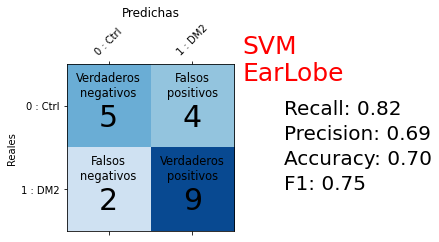

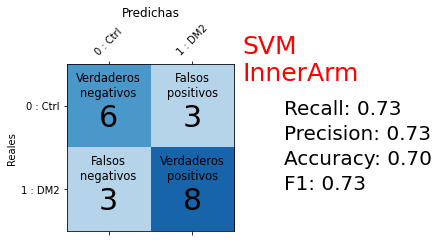

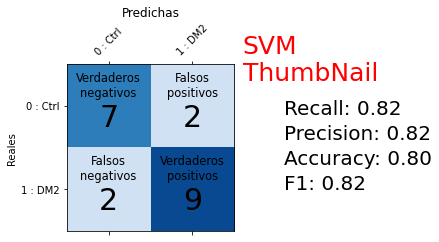

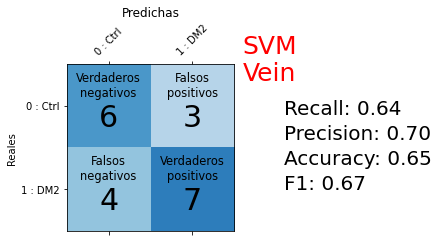

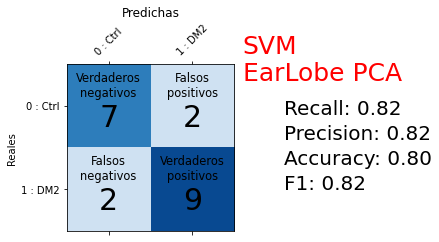

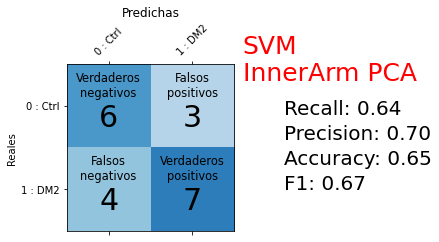

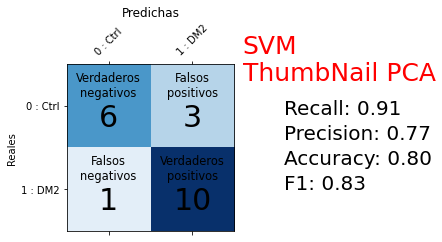

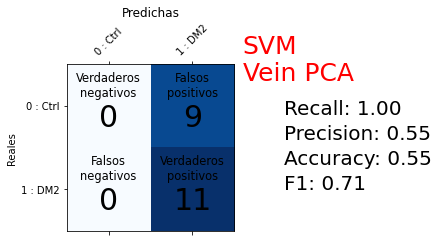

Tiempo transcurrido SVM: 0:01:27.536789


In [14]:
start_time_svm = time.time()
iter_df_plot_metrics(SVC(), RamanDF_preprocessed, param_grid_svm, 'SVM', 'GridSearchCV')
print(f'Tiempo transcurrido SVM: {timedelta(seconds=(time.time() - start_time_svm))}')

### Random Forest

In [15]:
# Se definen los hiperparámetros de búsqueda
param_grid_rf = dict()
param_grid_rf['n_estimators'] = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
param_grid_rf['max_features'] = ['auto', 'sqrt']
param_grid_rf['max_depth'] = [int(x) for x in np.linspace(10, 100, num = 10)]
param_grid_rf['max_depth'].append(None)
param_grid_rf['min_samples_split'] = [2, 5, 10]
param_grid_rf['min_samples_leaf'] = [1, 2, 4]
param_grid_rf['bootstrap'] = [True, False]
param_grid_rf['criterion'] = ['gini', 'entropy']

------------------------------------------------------------------------
Mejores resultados para EarLobe
recall:0.5, accuracy:0.85, precision:0.5, f1:0.5
Hiperparámetros: {'n_estimators': 673, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}
Tiempo transcurrido (best_model_grid_search_cv): 0:17:04.089926
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para InnerArm
recall:0.4, accuracy:0.55, precision:0.4, f1:0.4
Hiperparámetros: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Tiempo transcurrido (best_model_grid_search_cv): 0:15:58.347579
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejor

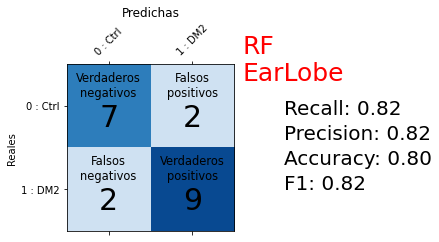

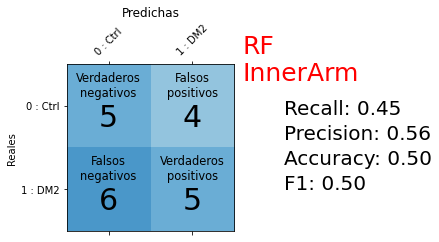

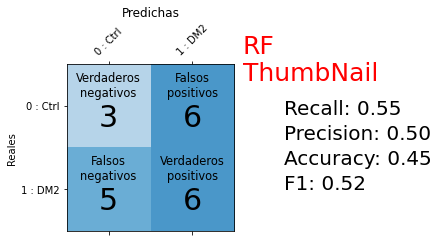

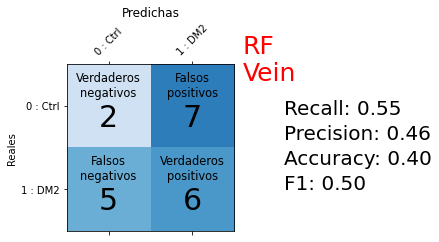

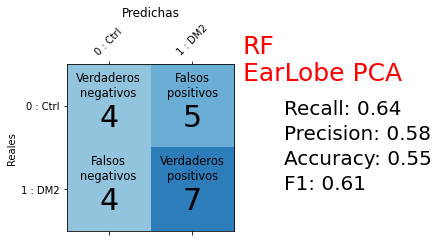

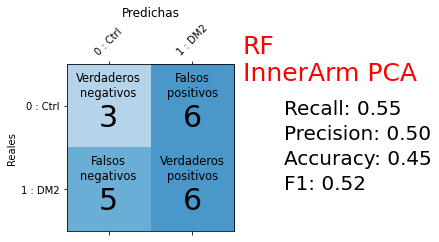

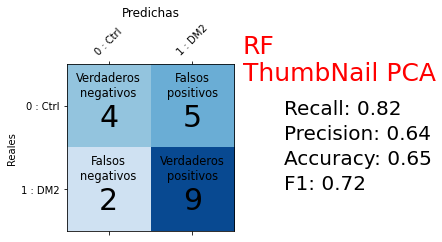

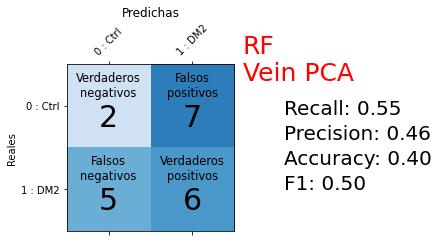

Tiempo transcurrido RF: 2:07:03.769259


In [16]:
start_time_rf = time.time()
iter_df_plot_metrics(RandomForestClassifier(), RamanDF_preprocessed, param_grid_rf, 'RF', 'RandomizedSearchCV')
print(f'Tiempo transcurrido RF: {timedelta(seconds=(time.time() - start_time_rf))}')

### Naive Bayes

In [17]:
# Se definen los hiperparámetros de búsqueda
param_grid_nb = dict()
param_grid_nb['var_smoothing'] = np.logspace(0,-9, num=100)

------------------------------------------------------------------------
Mejores resultados para EarLobe
recall:0.5, accuracy:0.8, precision:0.5, f1:0.5
Hiperparámetros: {'var_smoothing': 0.1873817422860384}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:26.733609
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para InnerArm
recall:0.45, accuracy:0.5, precision:0.45, f1:0.45
Hiperparámetros: {'var_smoothing': 0.657933224657568}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:25.115196
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para ThumbNail
recall:0.45, accuracy:0.5, precision:0.45, f1:0.45
Hiperparámetros: {'var_smoothing': 0.8111308307896871}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:23.447368
------------------------------

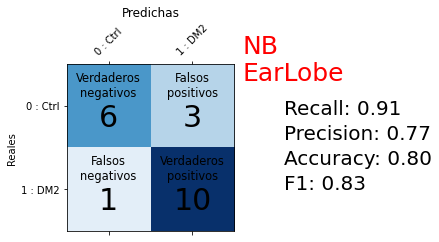

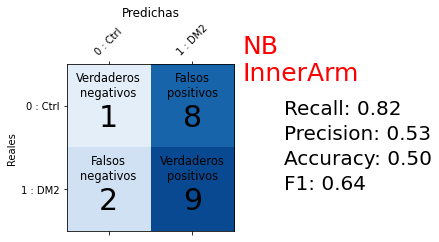

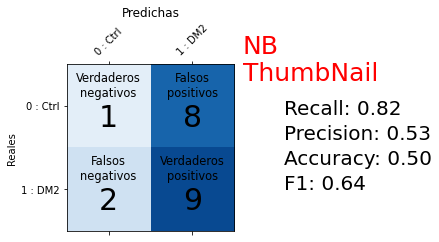

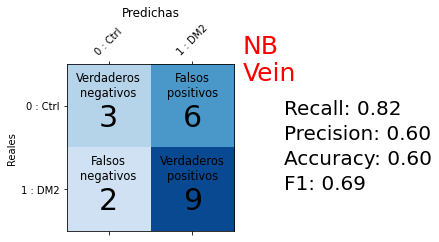

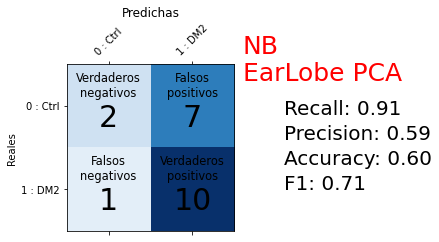

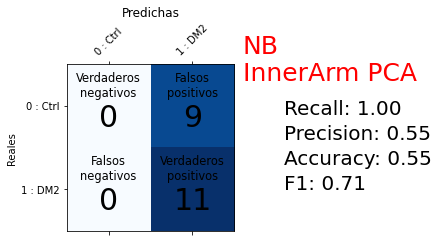

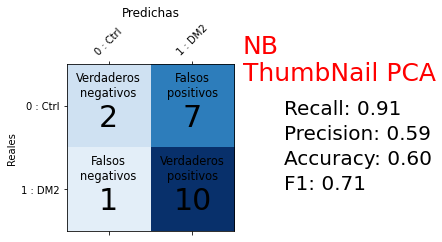

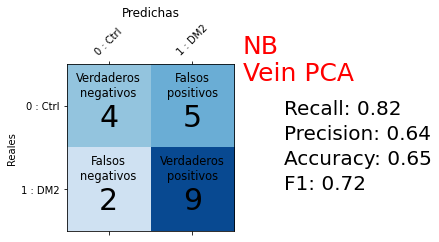

Tiempo transcurrido NB: 0:02:16.552659


In [18]:
start_time_nb = time.time()
iter_df_plot_metrics(GaussianNB(), RamanDF_preprocessed, param_grid_nb, 'NB', 'GridSearchCV')
print(f'Tiempo transcurrido NB: {timedelta(seconds=(time.time() - start_time_nb))}')

### K Nearest Neighbor

In [21]:
# Se definen los hiperparámetros de búsqueda
param_grid_knn = dict()
param_grid_knn['n_neighbors'] = list(range(1,10))
param_grid_knn['weights'] = ['uniform','distance']
param_grid_knn['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']
param_grid_knn['metric'] = ['minkowski','euclidean','manhattan']

------------------------------------------------------------------------
Mejores resultados para EarLobe
recall:0.5, accuracy:0.8, precision:0.5, f1:0.5
Hiperparámetros: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'minkowski', 'algorithm': 'ball_tree'}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:40.901200
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para InnerArm
recall:0.4, accuracy:0.65, precision:0.4, f1:0.4
Hiperparámetros: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Tiempo transcurrido (best_model_grid_search_cv): 0:00:25.793604
------------------------------------------------------------------------
------------------------------------------------------------------------
Mejores resultados para ThumbNail
recall:0.4, accuracy:0.5, precision:0.4, f1:0.4
Hiperparámetros: {'weights': 'distance', 'n_neighb

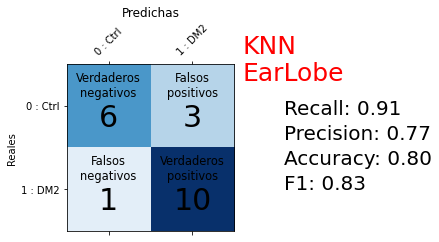

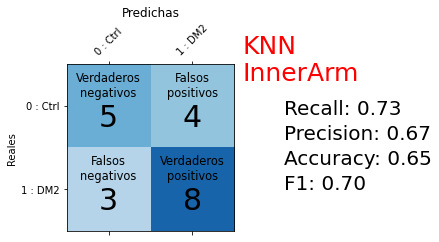

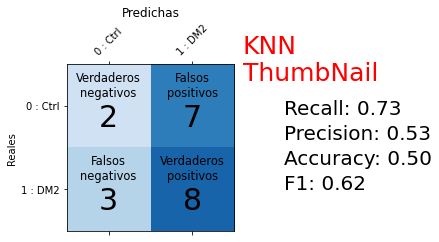

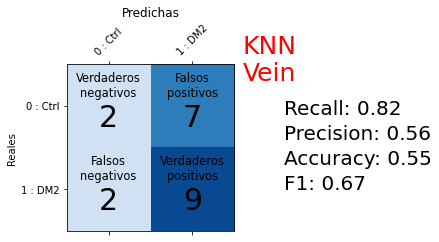

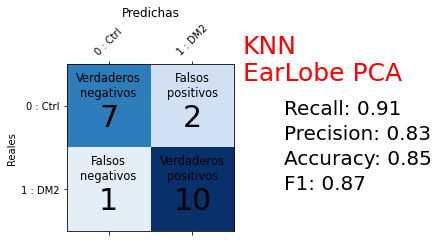

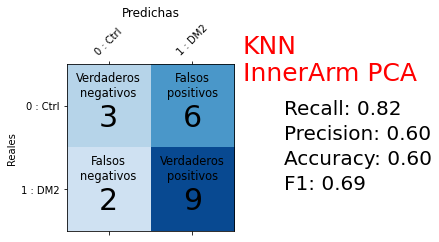

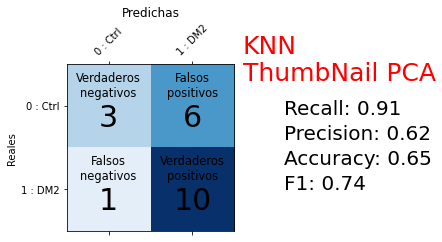

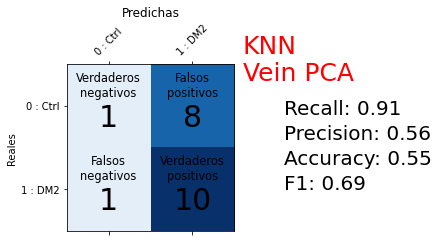

Tiempo transcurrido NB: 0:02:26.870891


In [22]:
start_time_knn = time.time()
iter_df_plot_metrics(KNeighborsClassifier(), RamanDF_preprocessed, param_grid_knn, 'KNN', 'RandomizedSearchCV')
print(f'Tiempo transcurrido NB: {timedelta(seconds=(time.time() - start_time_knn))}')